## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I will try to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#random.seed(42)

In [5]:
# Read the 'ab_data.csv' data set into df variable
df = pd.read_csv("ab_data.csv")

In [6]:
# Shows a top 5 rows as a sample from our data frame
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
# Using shape function to get the structure of our dataframe
df.shape[0]

294478

In [8]:
# Using nunique function to get the number of te unique values in the specified column
df.user_id.nunique()

290584

In [9]:
# Calculate the proportion of users who have value equal to 1 
# in "converted" column
user_conv_prop = df.query('converted == 1')["user_id"].count() / df.user_id.nunique()

# print user_conv_prop
user_conv_prop

0.12126269856564711

In [10]:
# "treat_dnot_newp_num" variable refers to how many times the treatment group
# comes with the old_page
treat_dnot_newp_num = df.query('group == "treatment" and landing_page != "new_page"').count()

# "newp_donot_treat_num" variable refers to how many times the new_page
# comes with the control group
newp_donot_treat_num = df.query('group != "treatment" and landing_page == "new_page"').count()

# total_num_treat_newp variable refers to the summation of above variables with each others
total_num_treat_newp = treat_dnot_newp_num[0] + newp_donot_treat_num[0]

# print total_num_treat_newp
total_num_treat_newp

3893

In [11]:
# Using info function to get detailed info about the columns 
# and how many values in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

Now I will remove those records and create new dataframe with the cleaned records.

In [12]:
# Creating new data frames df2, subset_1, subset_2
df2 = pd.DataFrame()
subset_1 = pd.DataFrame()
subset_2 = pd.DataFrame()

# Subset_1 dataframe has all the rows with 'treatment' group and 'new_page' as landing_page
subset_1 =df.query('group == "treatment" and landing_page == "new_page"')

# Subset_2 dataframe has all the rows with 'control' group and 'old_page' as landing_page
subset_2 =df.query('group == "control" and landing_page == "old_page"')

# Merge subset_1 with subset_2 into df2
df2= pd.merge(subset_1, subset_2, how="outer")

# Print the count of all records in df2
df2.count()[0]

290585

In [13]:
# Double Check all of the correct rows were removed - this should be 0
print(df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0])

print(df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0])

0
0


In [14]:
# Using nunique function to get the number of te unique values in the specified column
df2.user_id.nunique()

290584

In [15]:
# Get the repeated value of user_id in the newly created data frame df2
df2[df2.duplicated("user_id") == True].user_id

1404    773192
Name: user_id, dtype: int64

In [16]:
# Show the full row for user_id = 773192
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [17]:
# Drop the second index of the duplicated index
df2 = df2.drop_duplicates(subset=['user_id'], keep='first')

# Double check that the last repeated user_id has been deleted 
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [18]:
# Calculating the probability of individuals who converted wheter to the old_page 
# or the new_page 
indiv_prob = df2.query('converted == "1"')["user_id"].count() / df2.user_id.count()

# print indiv_prob
indiv_prob

0.11959708724499628

In [19]:
# Calculating the probability of being into control group and convert to the other page
indiv_convert_control_prob = df2.query('group == "control" and converted == "1"').count() / df2.query('group == "control"')["user_id"].count()

# print indiv_convert_control_prob
indiv_convert_control_prob[0]

0.1203863045004612

In [20]:
# # Calculating the probability of being into treatment group and convert to the other page
indiv_convert_treat_prob = df2.query('group == "treatment" and converted == "1"').count() / df2.query('group == "treatment"')["user_id"].count()

# print indiv_convert_treat_prob
indiv_convert_treat_prob[0]

0.11880806551510564

In [21]:
# Calculating the probability of receiving new_page as landing page for individulas
indiv_newp_prob = df2.query('landing_page == "new_page"')["user_id"].count() / df2.user_id.count()

# print indiv_newp_prob
indiv_newp_prob

0.50006194422266881

**Based on the calculted conversion probailities of 'control' & 'treatment' groups, it seems that being a user in the 'control' group have a higher probability (0.00157) to convert to the other page.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, I like to solve the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, We can consider that i need to make the decision just based on all the data provided.  I will assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

$$ H_0: p_{new} - p_{old} <= 0$$

$$H_1: p_{new} - p_{old} > 0$$


`2.` I will assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I will assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [22]:
# Calculate the convert_rate for the old_page
p_new = df2.converted.mean()

# print p_new
p_new

0.11959708724499628

In [23]:
# Calculate the convert_rate for the old_page
p_old = df2.converted.mean()

# print p_old
p_old

0.11959708724499628

In [24]:
# Calculate the proportion of new_page
n_new = df2.query('landing_page == "new_page"').count()[0]

# print n_old
n_new

145310

In [25]:
# # Calculate the proportion of old_page
n_old = df2.query('landing_page == "old_page"').count()[0]

#print n_old
n_old

145274

In [37]:
# Create new array 'new_page_converted' has 0,1 based on our random samples
new_page_converted = np.random.choice([0,1], size = n_new, p = [1-p_new, p_new])

# print  new_page_converted
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
# Create new array 'old_page_converted' has 0,1 based on our random samples
old_page_converted = np.random.choice([0,1], size = n_old, p = [1-p_old, p_old])

# print  old_page_converted
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
# Calculate the diff between the converted new/old means
diff = new_page_converted.mean() - old_page_converted.mean()

# print  diff
print(diff)

0.000245698993558


In [40]:
# Apply the Bootstraping Technique to calculate the diffs between our random samples
p_diffs = []
#for _ in range(10000):
#    newp_convert_samp = np.random.choice([0,1], size = n_new, p = [1-p_new, p_new])
#    oldp_convert_samp = np.random.choice([0,1], size = n_old, p = [1-p_old, p_old])
#    diff = newp_convert_samp.mean() - oldp_convert_samp.mean()
#    p_diffs.append(diff)

# Using built-in numpy funtion (bionomial) is more efficient in time than using For loop
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

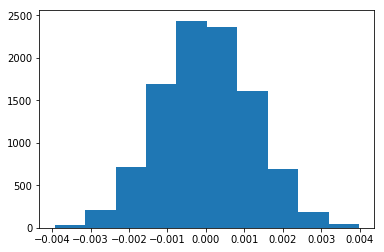

In [41]:
# Plot a histogram using the data calculated in the bootstrapping
plt.hist(p_diffs);

In [42]:
# Calculate the Null values using normal function
# null_vals = np.random.normal(0, np.std(p_diffs), 10000)

# Calculate the difference between the means of new/old pages
real_diff = (df2.query('landing_page == "new_page"').converted.mean()) - (df2.query('landing_page == "old_page"').converted.mean())

# Calculate p-value
p_value = (p_diffs > real_diff).mean()

# print p-value
print(p_value)

0.9058


**What we just computed in the above cell which is equal to (0.9058) is called p-value and in scientific studies, this value is the probability of obtaining the observed statistic or one more extreme in favor of the alternative hypothesis if null hypothesis is true. In simple words, while p_value which is equal to 0.9058 and significance level is equal to 0.05 which will lead that the p_value > significance level , and this will lead us to "fail to reject the null Hypothesis" which assumed that the old_page is better than or equal to the new_page**

Another possible technique to calculate P-Value using Ztest:

In [43]:
import statsmodels.api as sm
# Calculate new values to be used in the upcoming Ztest
convert_old = df2.query('landing_page == "old_page"').converted.mean()
convert_new = df2.query('landing_page == "new_page"').converted.mean()
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]
success_num_conv_old = int(n_old * convert_old)
success_num_conv_new = int(n_new * convert_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now I will use `stats.proportions_ztest` to compute my test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [44]:
# Calculate Ztest to get z_score and p-value
# choosing 'smaller' because we start the test with belief that the Null Hypothesis
# is the correct hypothesis until we have an evidance indicate something else
z_score, p_value_2 = sm.stats.proportions_ztest([success_num_conv_old,success_num_conv_new], [n_old,n_new], alternative="smaller")
# print Z_score
print(z_score)

# import norm lib
from scipy.stats import norm

# print p-value 
print(norm.cdf(z_score))

# The value to compared Z_score with to decide if we should accept/reject
# the Null Hypothesis/ the Alternative Hypothesis
critical_value = norm.ppf(1-(0.05/2))

# print critical_value
print(critical_value)

1.31092419842
0.905058312759
1.95996398454


what is the difference betwene the calculated p-value result from Ztest and the  p-value calculated from the bootstrapping Technique

**Z-score means how many standard deviations an element is from the mean. We can notice that the P_value_2 of (0.9) is the same with P_value of (0.9) which we get from the sampling distribution. Since the Z-score of (1.31092419842) do not exceeds the critical value of (1.95996398454), we fail to reject the Null Hypothesis between the two proportions. Thus, The findings of this cell are agreeing with the findings from Bootstrapping Technique.**

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

##### I will The simple Linear Regression in this case. #####

I will use **statsmodels** to fit the regression model I specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, firstly I need to create a column for the intercept, and create a dummy variable column for which page each user received. Also, I will create new column called as **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [45]:
# Create new two columns which are 'intercept' which is always 1
# And the other column is 'ab_page' which is equal 1 in case of 'treatment' group 
# and is equal to 0 else
df2['intercept'] = 1
df2['ab_page'] = np.where(df2['group'] == "treatment", 1, 0)


In [46]:
# Create and fit new regression model 
l = sm.OLS(df2['converted'], df2[['intercept', 'ab_page']])
results = l.fit()

In [47]:
# Get the results of our regression model 
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.719
Date:                Sun, 11 Nov 2018   Prob (F-statistic):              0.190
Time:                        11:31:09   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290582   BIC:                         1.706e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1204      0.001    141.407      0.000       0.119       0.122
ab_page       -0.0016      0.001     -1.311      0.190      -0.004       0.001
==============================================================================
Omnibus:                   125553.456   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414313.355
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>

**The P_value associated with ab_page is equal to (0.190). Also, ab_page is not statistically significant because its p-value (0.190) is greater than the significance level (0.05)**

**<br>The reason behind the different p_values in Part II and Part III is that the regression model assumes different alternative Hypothesis than the alternative Hypothesis used in the Ztest or Sampling Distribution**

**In other words, the Sampling distribution and Ztest are checking if one page performs better than the other page. Controversly, the regression model checks if the two pages are performing exactly the same or differently**

Now, I will consider other things that might influence whether or not an individual converts. Why it is a good idea to consider other factors to add into my regression model.  Are there any disadvantages to adding additional terms into my regression model?

**The Pros of using Multiple Linear Regression are two reasons. The first one is the ability to determine the relative influence of one/more predictor(s) to the criterion value. The second advantage is the ability to identify outliers/anomalies.**


**The most noted disadvatage using Multiple Linear Regression is that the whole analysis can go seriously wrong if there are severe outliers or influential cases.**

Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. I will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

##### Does it appear that country had an impact on conversion?.#####

We will create dummy variables for these country columns. Also, Providing the statistical output as well as a written response to answer this question.

In [48]:
# read the 'countries.csv' file
countries_df = pd.read_csv('countries.csv')
countries_df.head()

# Get the number of unqiue entries to know how many dummy column will be created
countries_df.country.unique()

merged_df = df2.join(countries_df.set_index('user_id'), on='user_id')

# Double check on the merged columns
merged_df.head()

# Create new dummies columns
merged_df[['CA','UK','US']] = pd.get_dummies(merged_df['country'])

# Double check on the newly created dummies columns
merged_df.head()

# Create and fit the new regression model and get the results of it.
lm = sm.OLS(merged_df['converted'], merged_df[['intercept','CA','UK']])
results = lm.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.605
Date:                Sun, 11 Nov 2018   Prob (F-statistic):              0.201
Time:                        11:34:00   Log-Likelihood:                -85267.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1195      0.001    166.244      0.000       0.118       0.121
CA            -0.0042      0.003     -1.516      0.130      -0.010       0.001
UK             0.0010      0.001      0.746      0.455      -0.002       0.004
==============================================================================
Omnibus:                   125552.384   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414306.036
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         4.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**So my interpretation about the above regression model will be the follwoing:
<br></br>
<br> 1- The predicted converstion rate expected to be 11.95% regardless of the country. In other words, If the country was US, we are predicting the converstion rate to be 11.95%.</br>
<br> 2- If the country is CA, then we are predicting the converstion rate to be 0.42% less than the conversation rate in the US. </br>
<br> 3- If  the country is UK, then we are predicting the conversation rate to be increased by 0.10% rather than the conversation rate in the US. </br>** 
**<br> 4- Neither CA nor UK a statistically significant because their p-value (0.130),(0.455) respectively are greater than the significance level (0.05). </br>** 
**<br> 5- It is recommened to remove any non statisitcal signficant variable from our regression model to save it precision's level. </br>** 

h. Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if there significant effects on conversion. I will create the necessary additional columns, and fit the new model.

In [49]:
# Create new columns int eh merged data frame.
# Those columns indicate the country and page effect together.
# We will use them in our  next regression model.
merged_df['US_ab_page'] = merged_df['US']*merged_df['ab_page']
merged_df['UK_ab_page'] = merged_df['UK']*merged_df['ab_page']
merged_df['CA_ab_page'] = merged_df['CA']*merged_df['ab_page']

# Create and fit the new regression model and get the summary of it.
lm = sm.OLS(merged_df['converted'], merged_df[['intercept','UK_ab_page','CA_ab_page']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.477
Date:                Sun, 11 Nov 2018   Prob (F-statistic):             0.0840
Time:                        11:34:45   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290581   BIC:                         1.706e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1196      0.001    183.238      0.000       0.118       0.121
UK_ab_page     0.0016      0.002      0.862      0.388      -0.002       0.005
CA_ab_page    -0.0077      0.004     -1.996      0.046      -0.015      -0.000
==============================================================================
Omnibus:                   125551.115   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414297.332
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         6.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**My interpretation for the above regression model which look at an interaction between the page and the country will be the following:**

**<br>1- The predicted converstion rate expected to be 11.95% regardless of the country and the page. In other words, If the country was US, we are predicting the converstion rate to be 11.95% regardless of the page</br>** 
**<br>2- If the country is UK, there is no statistical significant evidence betwene the conversion rate and the page/country, because p-value(0.388) is greater than the significance level (0.05)**
**<br>3- If the country is CA, there is no statistical significant evidence betwene the conversion rate and the page/country, because p-value(0.046) is greater than the significance level (0.05)</br>.**